In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data from csv file and creating a pandas dataframe

In [2]:
path_to_csv = 'insurance.csv'
df_original = pd.read_csv(path_to_csv)

# Exploratory Data Analysis
Let's explore the data for our tasks: dataset features and target variables, types of features, the number of entries, presence of NaN values.

In [3]:
df_original.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
print(df_original.shape)
print(df_original.isnull().any().any())
df_original.dtypes

(1338, 7)
False


age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

There is 1338 entries with 7 features ('charges' is the target feature) and there are no NaN values in dataframe.

There are several non-numerical features: binary ('sex' and 'smoker') and categorical ('region'). This can be a problem for further data analysis and prediction. 

Let's preprocess the data and look at the dataset after that.

In [5]:
df = df_original.copy()
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['region'] = df['region'].astype('category').cat.codes

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Let's look at the statistics for our data.

In [7]:
df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


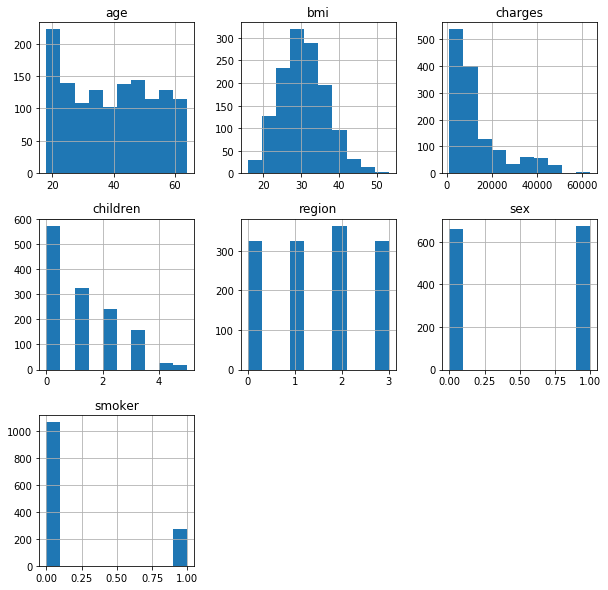

In [8]:
df.hist(figsize=(10,10))
plt.show()

## Feature Analysis
At the moment its hard to say, what features are the most important for prediction. Let's compute the Pearson correlation between features and target variable to find it out.

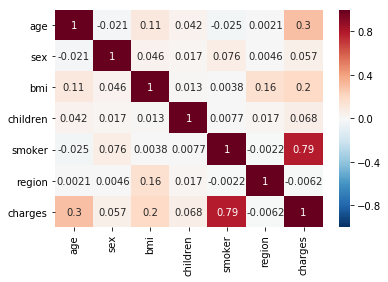

In [9]:
import seaborn as sns
var_corr = df.corr()
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, 
            annot=True, vmin=-1, vmax=1, cmap= 'RdBu_r')
plt.show()

In [10]:
var_corr['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region     -0.006208
Name: charges, dtype: float64

'smoker', 'age' and 'bmi' appears to be the most important features, their correlation with target variable is rather large. At the same time, other features seem to be far less meaningful, their correlation with target variable is close to zero.

Based on that, we will use only these three most important features for further prediction. Removing unnecessary features will make data less noisy and will reduce the risk of overfitting.

In [11]:
cols = ['smoker', 'age', 'bmi', 'charges']
df_meaningful = df[cols]

Let's visualize the relations between this features and target:

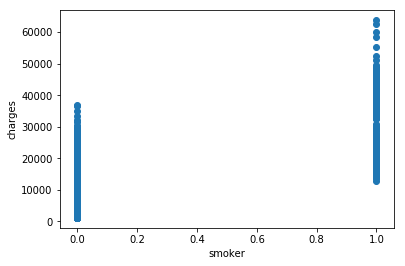

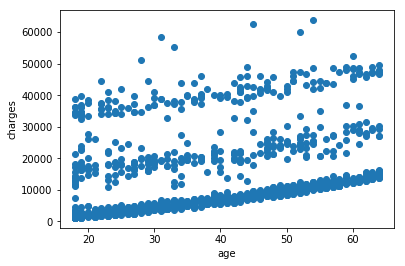

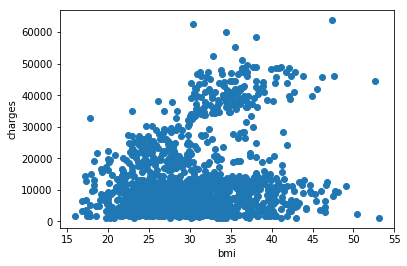

In [12]:
for c in cols[:-1]:
    plt.figure()
    plt.scatter(df_meaningful[c], df_meaningful['charges'])
    plt.xlabel(c)
    plt.ylabel('charges')    
    plt.show()

Analyzing the plots we can say that, smokers tend to be charged more. Charges also grow along with age and bmi.  

Let's check the correlation between new features:`

In [13]:
df_meaningful.corr()

,smoker,age,bmi,charges
smoker,1.000000,-0.025019,0.003750,0.787251
age,-0.025019,1.000000,0.109272,0.299008
bmi,0.003750,0.109272,1.000000,0.198341
charges,0.787251,0.299008,0.198341,1.000000


As shown, there is no significant correlation between features, so further we should not worry about feature multicollinearity.

# Data Preparation
Further we will try several machine learning techniques to solve the task. To compare methods efficiency and check whether they suffer from overfittting we will need to split data into train and test sets.

Since the amount of available data is not very big, we will use classic strategy for splitting data: 70% for training set and 30% for testing set. That should be enough for both training the models and evaluating their performance.

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_meaningful, test_size=0.3, random_state=1)

train.shape[0], test.shape[0]

(936, 402)

So we have 936 train samples and 402 test samples.

Some of the methods that we are going to use require normalization (or standartization) of data. Of course, the type of normalization (or decision of not using normalization at all) should be picked individually for every particular method. However, since we wish to try as many methods as possible and focus on exploring their particular properties, we decided to use the same normalization for all of them. 

We decided to use standartization, because it's less sensitive to outliers, than min-max normalization

Both train and test set should be normalized using statistics of the train set.

In [15]:
from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()

train, test = train.copy(), test.copy()  # split returns view of source dataframe 
train_y_std, train_y_mean = train['charges'].std(), train['charges'].mean()  # we will need it later
print(train_y_std, train_y_mean)

train[train.columns] = scaler.fit_transform(train)
test[test.columns] = scaler.transform(test)

train_x, train_y = train.loc[:, train.columns != 'charges'], train['charges']
test_x, test_y = test.loc[:, test.columns != 'charges'], test['charges']

12197.308212562428 13276.698553898494


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


# Solving the Task

The task of predicting charges using customers features is a regression task (because we want to predict a real continuous number).

We are going to try several machine learning methods for regression tasks, including linear regression, decision trees, neighrest neighbours, gradient boosting and random forest. We will also build and train a simple MLP neural network.

For evaluating the models and comparing their performance, will need to choose a score functions. R2 score - coefficient of determination - seems reasonable for this task (the best possible score is 1).

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def compute_test_score(algorithm, x=test_x, y=test_y):
    prediction = algorithm.predict(x)
    return r2_score(y, prediction)

scores_dict = {}
models_dict = {}

Before going further, it's important to notice that obtained estimates are not enough to objectively evaluate the efficiency of the method. For comprehensive analysis we would also need to try different hyperparameters, data preprocessing, train/test sizes, normalization techniques, etc. Moreover, in cases when we try different hyperparameters for the method we choose the best one using holdout method. K-fold or LOO could give better results.

# Linear Regression
Linear regression is probably the simplest regression method. Based on the assumption that the relationship between features and target is a linear function, the goal of the method is to estimate the coefficients of this function.

In [17]:
from sklearn.linear_model import LinearRegression

regr_linear = LinearRegression()
regr_linear.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
score = compute_test_score(regr_linear)
scores_dict['Linear Regression'] = score
models_dict['Linear Regression'] = regr_linear
score

0.7349606898512976

Let's look at the coefficients of each feature:

In [19]:
coefficients = pd.DataFrame(regr_linear.coef_, index=train_x.columns, columns=['coef'])
coefficients

,coef
smoker,0.797220
age,0.290853
bmi,0.152395


Expectedly, the smoker factor seems to be the most important. Obtained results go along well with Pearson correlation, that was computed for original database.

The main drawback of the linear regression model is that it's not capable of modeling data more complex, than linear.

# kNN
kNN is a non-parametrical metric method. The predicted value of the target variable ('charges' in our case) is the average between values of its K nearest neighbors.

Let's choose the best values for K, weights of neighbors and metric using grid search with KFold cross valisation.

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

k_values = range(1, 20, 2)
cv=KFold(n_splits=3, shuffle=True, random_state=0)

min_error = -np.inf
best_k = -1
best_knn = None

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_x, train_y)
    test_error = cross_val_score(knn, train_x, train_y, cv=cv, scoring="neg_mean_squared_error").mean()
    if test_error > min_error:
        min_error = test_error
        best_k = k
        best_knn = knn
        
print(f'Best k: {best_k}, test error: {-min_error:.5f}')
score = compute_test_score(best_knn)
scores_dict['kNN'] = score
models_dict['kNN'] = best_knn
score

Best k: 15, test error: 0.16734


0.8499284200855076

The main disadvantage of kNN algorithm is the complexity of computing distances between new sample and all the train samples. In case when there are a lot of features it can be an extremely expensive computational operation.

# Decision Tree
Decision Trees is a simple, fast (O(n) during training and O(log n) during prediction) and yet efficient method for solving classification and regression tasks, especially in cases, when the number of features is small.

The most important parameter of decision tree is its depth. Since decision tree is a greedy algorithm, it tends to excessively increase the depth of the tree with leaves containing very few examples, and hence suffers from overfitting.

Let's try to train a decision tree regressor without specifying it's max_depth and check it's depth and test error.

In [21]:
from sklearn.tree import DecisionTreeRegressor

regr_tree = DecisionTreeRegressor()
regr_tree.fit(train_x, train_y)
depth = regr_tree.tree_.max_depth
test_score = compute_test_score(regr_tree)
print(f'Depth: {depth}, test score: {test_score:.5f}')

Depth: 22, test score: 0.67099


Depth of 22 seems to be too much for a task with only 3 features. Small score also indicates possible overfitting.

Let's build several decision trees with different max_depths and choose the one with the minimum test error.

In [22]:
depth_values = range(1, 23)  # check all depths in range from 1 to depth, that was chosen automatically (22)

max_score = -np.inf
best_depth = -1
best_tree = regr_tree

for depth in depth_values:
    regr_tree = DecisionTreeRegressor(max_depth=depth)
    regr_tree.fit(train_x, train_y)
    test_score = compute_test_score(regr_tree, test_x, test_y)
    if test_score > max_score:
        max_score = test_score
        best_depth = depth
        best_tree = regr_tree
        
print(f'Best depth: {best_depth}, test score: {max_score:.5f}')
scores_dict['Decision Tree'] = max_score
models_dict['Decision Tree'] = best_tree

Best depth: 4, test score: 0.84807


The best depth for decision tree is 4.

On the analogy with linear regression, we can look at importance of each feature:

In [23]:
feature_importances = pd.DataFrame(best_tree.feature_importances_, index=train_x.columns, columns=['importance'])
feature_importances

,importance
smoker,0.730470
age,0.108644
bmi,0.160885


# Random Forest
Random forest is method, based on bagging (ensembling) decision trees. Let's choose the same max_depth (equal to 4), that resulted in best performance for single decision tree.

In [24]:
from sklearn.ensemble import RandomForestRegressor

regr_rf = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=0)
regr_rf.fit(train_x, train_y)
score = compute_test_score(regr_rf)
scores_dict['Random Forest'] = score
models_dict['Random Forest'] = regr_rf
score

0.854081797856749

As expected, ensembling of 100 trees improved the score significantly. 

# Gradient Boosting
Gradient boosting is another ensempling method. Unlike bagging, it's an iterative technique in which observations are weighted based on previous estimators result.

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

regr_grad = GradientBoostingRegressor(random_state=0)
regr_grad.fit(train_x, train_y)
score = compute_test_score(regr_grad)
scores_dict['Gradient Boosting'] = score
models_dict['Gradient Boosting'] = regr_grad
score

0.8556880883283207

Gradient boosting is a really powerful method as evidenced by its results. It's the best model we tried so far.

# Neural Network

Although using a neural network seems to be somewhat overkill for this task, it's still interesting to compare its performance with classical machine learning approaches.

As known, neural network with only linear layers without activation functions is basically the same as linear regression. We'll check it out  below(option n_layers=1).

We'll also train a MLP neural network with different number of hidden layers (2, 5 and 10) and compare its performance with classical machine learning approaches.

All models will be trained for 10000 iterations.

In [26]:
import torch
import torch.nn as nn

torch.manual_seed(0)

In [27]:
class LinearNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, n_layers=1):
        super(LinearNet, self).__init__()
        
        if n_layers == 1:
            self.model = nn.Linear(input_dim, output_dim)
            
        else:
            model = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
            
            for i in range(n_layers-2):
                model.append(nn.Linear(hidden_dim, hidden_dim))
                model.append(nn.ReLU())
                
            model.append(nn.Linear(hidden_dim, output_dim))
#             model.append(nn.ReLU())
            self.model = nn.Sequential(*model)
        
    def forward(self, input):
        out = self.model(input)
        return out

In [28]:
num_layers = [1, 2, 5, 10]

train_x_tensor = torch.tensor(train_x.values.astype(np.float32))
train_y_tensor = torch.tensor(train_y.values.astype(np.float32)).unsqueeze(-1)

test_x_tensor = torch.tensor(test_x.values.astype(np.float32))
test_y_tensor = torch.tensor(test_y.values.astype(np.float32)).unsqueeze(-1)

In [29]:
for n in num_layers:
    print(f'-----{n}-layer MLP-----')
    model = LinearNet(input_dim=3, hidden_dim=5, n_layers=n)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss()
    
    for iter in range(10001):
   
        y_pred = model(train_x_tensor)
        train_loss = criterion(train_y_tensor, y_pred)
        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        if iter % 2000 == 0:
            model.eval()

            y_pred_val = model(test_x_tensor)
            val_loss = criterion(test_y_tensor, y_pred_val)

            print(f'Iter {iter}: train loss: {train_loss.item():.5f},\
                    validation loss: {val_loss.item():.5f}')

            model.train()
    y_pred = model(test_x_tensor).detach().numpy()
    score = r2_score(test_y, y_pred)
    scores_dict[f'{n}-layer NN'] = score
    models_dict[f'{n}-layer NN'] = model

-----1-layer MLP-----
Iter 0: train loss: 1.47283,                    validation loss: 1.42484
Iter 2000: train loss: 0.88036,                    validation loss: 0.85533
Iter 4000: train loss: 0.52849,                    validation loss: 0.51805
Iter 6000: train loss: 0.34376,                    validation loss: 0.34100
Iter 8000: train loss: 0.26775,                    validation loss: 0.26818
Iter 10000: train loss: 0.24904,                    validation loss: 0.25247
-----2-layer MLP-----
Iter 0: train loss: 1.18706,                    validation loss: 1.12299
Iter 2000: train loss: 0.56965,                    validation loss: 0.54642
Iter 4000: train loss: 0.24156,                    validation loss: 0.24054
Iter 6000: train loss: 0.17055,                    validation loss: 0.16789
Iter 8000: train loss: 0.15954,                    validation loss: 0.15005
Iter 10000: train loss: 0.15915,                    validation loss: 0.14893
-----5-layer MLP-----
Iter 0: train loss: 1.1125

Networks results will be discussed in the next section.

# Models Comparison

In [30]:
scores_df = pd.DataFrame.from_dict(scores_dict.items())
scores_df.columns = ['Model', 'Score']

In [31]:
scores_df

,Model,Score
0,Linear Regression,0.734961
1,kNN,0.849928
2,Decision Tree,0.848067
3,Random Forest,0.854082
4,Gradient Boosting,0.855688
5,1-layer NN,0.735236
6,2-layer NN,0.843817
7,5-layer NN,0.861538
8,10-layer NN,0.852468


As it was stated in neural networks section, linear network without activation functions is the same as linear regression, which can be seen in scores.

Neural networks with activations resulted in great scores and outperformed other models. 

The best scores were obtained using ensemble models (random forest and gradient boosting) and neural networks with activations. However, the gap between performance of classical machine learning networks and neural networks is not so crucial. In most cases accuracy of classical methods is sufficient and it's not worth training a neural network, which takes quite a long time.

# Visualizing Results
Let's predict charges for test set using each model (except 1-layer NN), denormalize features and visualize the results:

In [32]:
def denormalize(sample, mean=train_y_mean, std=train_y_std):
    return sample * train_y_std + train_y_mean

test_y_predicted = {}

test_y_predicted['Ground truth'] = denormalize(test['charges'])

for model_name, model in models_dict.items():
    if model_name == '1-layer NN':
        continue
    elif 'layer NN' in model_name:
        prediction = model(test_x_tensor).detach().squeeze().numpy()
    else:
        prediction = model.predict(test_x)
    test_y_predicted[model_name] = denormalize(prediction)

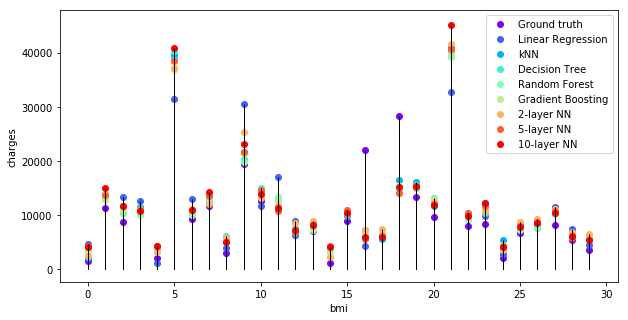

In [33]:
from matplotlib import cm

n = 30  # number of samples to display

plt.figure(figsize=(10,5))
colors = cm.rainbow(np.linspace(0, 1, len(test_y_predicted)))
for ind, (model_name, y) in enumerate(test_y_predicted.items()):
    plt.scatter(list(range(n)), list(y[:n]), color=colors[ind], label=model_name)
    plt.vlines(np.arange(n), ymin=np.zeros(n), ymax=y[:n], linewidth=1)
    plt.xlabel(c)
    plt.ylabel('charges')    
plt.legend()
plt.show()

Except some outliers, results look pretty good :)

Let's compare prediction made by one of the models (for example, gradient boosting) with ground truth value:

In [36]:
ind = np.random.choice(test_x.shape[0])  # select random sample
x_sample = np.expand_dims(test_x.iloc[ind].to_numpy(), axis=0)
y_sample = denormalize(test_y.iloc[ind])
y_pred = denormalize(models_dict['Gradient Boosting'].predict(x_sample))
print(f'Predicted charges: {y_pred[0]} / Ground truth charges: {y_sample}')

Predicted charges: 13344.967334007968 / Ground truth charges: 12235.282739466307


# Summary
In this notebook we:
- analysed the data and features;
- found the most important features ('smoker', 'age' and 'bmi');
- tested a bunch of machine learning algorithms (linear regression, knn, decision trees, random forest and gradient boosting) and trained several neural networks with different number of layers. Ensemble models and neural networks showed the best scores;
- evaluated performances of these models;
- visualized their results.